# Imports

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pandas as pd
import pandas.io.sql as psql
from sqlalchemy import create_engine, text
import yaml
from pathlib import Path
import os

import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score

project_dir = Path('__main__').resolve().parent.parent

# Load Data

In [2]:
db_params = yaml.safe_load(open(os.path.join(project_dir, 'src', 'data', 'config', 'postgresql_config.yaml'), 'rb'))
#db_params = {
#    'host': 'silly.db.elephantsql.com',
#    'database': '********',
#    'user': '********',
#    'password': '********'
#}

In [3]:
#Criando conexão
conn = psycopg2.connect(
    host=db_params['host'],
    database=db_params['database'],
    user=db_params['user'],
    password=db_params['password']
)

In [4]:
# Create a cursor object
cur = conn.cursor()

# Set automatic commit to be true, so that each action is committed without having to call conn.committ() after each command
conn.set_session(autocommit=True)

In [5]:
query = '''
SELECT
  *
FROM PHISHING_DATA_PROCESSED
'''

In [6]:
df = psql.read_sql(query, conn)
df

/tmp/ipykernel_8450/4116470484.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = psql.read_sql(query, conn)


,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,...,n_hastag,n_dollar,n_percent,n_redirection,phishing,perc_pontos,perc_hifens,perc_hifens_pontos,porte_url,tem_ponto_interrogacao
0,37,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.081081,0.000000,0.081081,PEQUENA,NAO
1,77,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.012987,0.000000,0.012987,MEDIA,NAO
2,126,4.0,1.0,2.0,0.0,1.0,3.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.031746,0.007937,0.039683,GRANDE,SIM
3,18,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.111111,0.000000,0.111111,PEQUENA,NAO
4,55,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.036364,0.036364,0.072727,MEDIA,NAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89527,23,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.130435,0.043478,0.173913,PEQUENA,NAO
89528,34,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.058824,0.000000,0.058824,PEQUENA,NAO
89529,70,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.028571,0.014286,0.042857,MEDIA,NAO
89530,28,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.071429,0.000000,0.071429,PEQUENA,NAO


# Mapear Dados (FAZER DEPOIS DE QUEBRAR A ARVORE)

In [36]:
from sklearn.preprocessing import OrdinalEncoder

In [37]:
encoder = OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1)

In [41]:
colunas_string = df.select_dtypes(include=['object', 'string']).columns.tolist()
colunas_string

['porte_url', 'tem_ponto_interrogacao']

In [42]:
encoder.fit(df[colunas_string])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [46]:
encoder.categories_

[array(['GRANDE', 'MEDIA', 'PEQUENA'], dtype=object),
 array(['NAO', 'SIM'], dtype=object)]

In [43]:
df[colunas_string] = encoder.transform(df[colunas_string])

In [44]:
df.head()

,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,...,n_hastag,n_dollar,n_percent,n_redirection,phishing,perc_pontos,perc_hifens,perc_hifens_pontos,porte_url,tem_ponto_interrogacao
0,37,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.081081,0.000000,0.081081,2.0,0.0
1,77,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.012987,0.000000,0.012987,1.0,0.0
2,126,4.0,1.0,2.0,0.0,1.0,3.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.031746,0.007937,0.039683,0.0,1.0
3,18,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.111111,0.000000,0.111111,2.0,0.0
4,55,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.036364,0.036364,0.072727,1.0,0.0


# Separar os Dados - Treino e Teste

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='phishing'), df['phishing'], 
                                                    test_size=0.3, random_state=777, stratify=df['phishing'])

In [49]:
print("Shape dataset de treino: ", X_train.shape)
print("Shape dataset de teste: ", X_test.shape)

Shape dataset de treino:  (62672, 24)
Shape dataset de teste:  (26860, 24)


In [50]:
print("Percentual de phishings no treino: ", round(y_train.mean()*100, 1), "%")
print("Percentual de phishings no teste: ", round(y_test.mean()*100, 1), "%")

Percentual de phishings no treino:  36.2 %
Percentual de phishings no teste:  36.2 %


# Árvore de Decisão

In [51]:
from sklearn.tree import DecisionTreeClassifier

In [78]:
clf = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=777)

In [79]:
clf.fit(X = X_train, y = y_train)

DecisionTreeClassifier(max_depth=5, random_state=777)

# Visualizando a Árvore

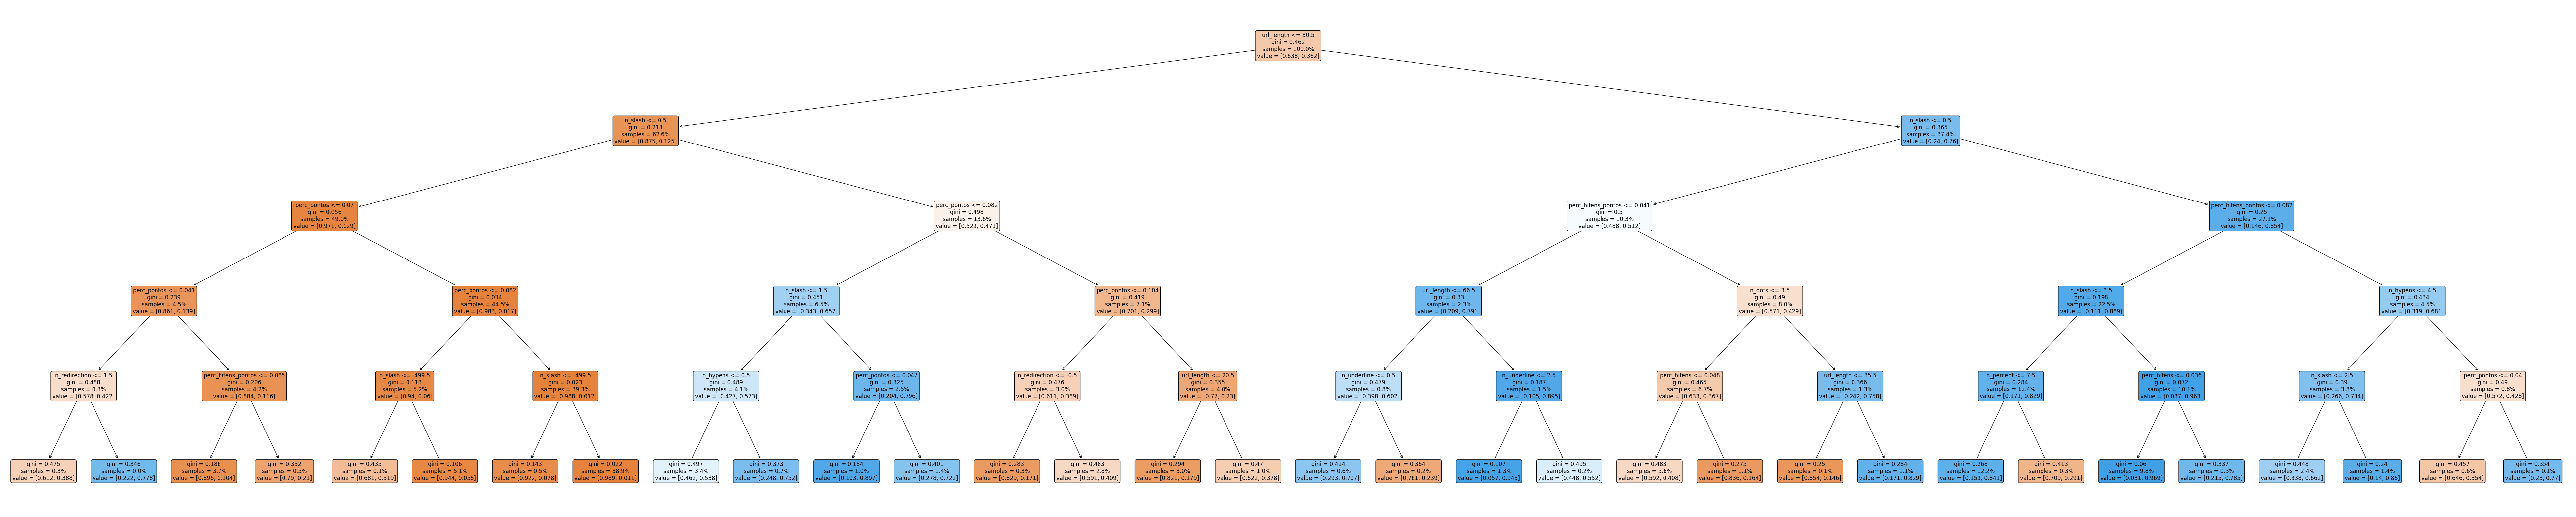

In [82]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(100,20))  
_ = tree.plot_tree(clf, feature_names = X_train.columns, 
             filled=True, fontsize=12, rounded = True, label='all', proportion=True)
plt.show()

# Avaliando a Performance da Árvore

In [83]:
from sklearn.metrics import precision_score

In [88]:
precision_score(y_train, clf.predict(X_train))

0.8297297297297297

In [89]:
precision_score(y_test, clf.predict(X_test))

0.8236083858308375

# Salvando Modelo

In [90]:
import pickle

In [92]:
pickle.dump(clf, open(os.path.join(project_dir, 'models', 'primeiro-modelo-arvore-decisao.pkl'), 'wb'))